In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import perf_counter     
from IPython.display import clear_output
from torch.optim import LBFGS, Adam

# Definizioni ausiliarie
class Core(object):
    def __init__(self, device):
        self.dtype = torch.float
        self.device = torch.device("cpu") if (device.lower() == "cpu") else torch.device("cuda:0")
                        
    def tensor(self, array):
        return torch.tensor(array, dtype = self.dtype, device = self.device)
            
    def load(self, *paths):
        return torch.cat(tuple([self.tensor(np.load(path)) for path in paths]))
    
CPU, GPU = Core("CPU"), Core("GPU")
leakyReLU = torch.nn.LeakyReLU(0.1) #torch.nn.tanh; torch.nn.sigmoid; torch.nn.relu 
tanh = torch.tanh
sigmoid = torch.sigmoid

class Dense(torch.nn.Module):
    def __init__(self, input_dim, output_dim, activation = leakyReLU):
        super(Dense, self).__init__()
        self.lin = torch.nn.Linear(input_dim, output_dim)
        self.rho = activation if (activation != None) else torch.nn.Identity()
        self.core = CPU    
    def w(self):
        return self.lin.weight
    def b(self):
        return self.lin.bias
    def forward(self, x):
        return self.rho(self.lin(x))
    def cuda(self):
        self.lin.cuda()
    def cpu(self):
        self.lin.cpu()
    def He(self):
        torch.nn.init.kaiming_normal_(self.lin.weight, mode='fan_out', nonlinearity='leaky_relu', a = 0.1)
    def HeTanh(self):
        torch.nn.init.kaiming_normal_(self.lin.weight, mode='fan_out', nonlinearity='tanh')
    def freeze(self):
        self.lin.requires_grad_(False)
    def unfreeze(self):
      self.lin.requires_grad_(True)
    def dictionary(self, label = ""):
        return {('w'+label):self.w().detach().cpu().numpy(), ('b'+label):self.b().detach().cpu().numpy()}
    def parameters(self):
        return list(self.lin.parameters())
    def load(self, w, b):
        self.lin.weight = torch.nn.Parameter(self.core.tensor(w))
        self.lin.bias = torch.nn.Parameter(self.core.tensor(b))
    def __add__(self, other):
        if(isinstance(other, Consecutive)):
            n = len(other)
            layers = [self]+[other[i] for i in range(n)]
            return Consecutive(*tuple(layers))
        else:
            return Consecutive(self, other)    

class Consecutive(torch.nn.Sequential):
    def cuda(self):
        for nn in self:
            nn.cuda()
    def cpu(self):
        for nn in self:
            nn.cpu()
    def He(self):
        for nn in self:
            nn.He()
    def HeTanh(self):
        for nn in self:
            nn.HeTanh()
    def parameters(self):
        p = []
        for f in self:
            p += list(f.parameters())
        return p
    def freeze(self):
        for f in self:
            f.freeze()
    def unfreeze(self):
        for f in self:
            f.unfreeze()
    def save(self, path):
        params = self.dictionary()
        np.savez(path, **params)
    def load(self, path):
        try:
            params = np.load(path)
        except:
            params = np.load(path+".npz")
        for k in range(len(self)):
            self[k].load(params['w'+str(k)], params['b'+str(k)])
    def dictionary(self):
        params = dict()
        for k in range(len(self)):
            params.update(self[k].dictionary(str(k)))
        return params
    def __add__(self, other):
        if(isinstance(other, Consecutive)):
            n1 = len(self)
            n2 = len(other)
            layers = [self[i] for i in range(n1)]+[other[i] for i in range(n2)]
            return Consecutive(*tuple(layers))
        else:
            n1 = len(self)
            layers = [self[i] for i in range(n1)]
            layers.append(other)
            return Consecutive(*tuple(layers))     

class Clock(object):   
    def __init__(self):
        self.tstart = 0
        self.tstop = 0
    def start(self):
        self.tstart = perf_counter()
    def stop(self):
        self.tstop = perf_counter()
    def elapsed(self):
        dt = self.tstop-self.tstart 
        if(dt<0):
            raise RuntimeError("Clock still running.")
        else:
            return dt 
    def elapsedTime(self):
        return Clock.parse(self.elapsed())
    @classmethod
    def parse(cls, time):
        h = time//3600
        m = (time-3600*h)//60
        s = time-3600*h-60*m
        if(h>0):
            return ("%d hours %d minutes %.2f seconds" % (h,m,s))
        elif(m>0):
            return ("%d minutes %.2f seconds" % (m,s))
        else:
            return ("%.2f seconds" % s)

In [ ]:
#PROBLEMA DIRETTO
import sys

x = np.load("/content/drive/MyDrive/POD-NN_brain/data_in0.npy")
y = np.load("/content/drive/MyDrive/POD-NN_brain/data_out_phi0.npy")
N_data=10

for ii in range(1,N_data):
  x_ = np.load("/content/drive/MyDrive/POD-NN_brain/data_in"+str(ii)+".npy")
  y_ = np.load("/content/drive/MyDrive/POD-NN_brain/data_out_phi"+str(ii)+".npy")
  
  x=np.concatenate((x,x_))
  y=np.concatenate((y,y_))

#print(x[:30])

print(x)
l_bounds =np.array([800.0,0.05811,0.15,10000.0,0.03,10000.0,0.0]) #np.array([3000.0,3000.0,0.27,0.05,0.1,0.0]) #np.array([5.0e+03,2000.0,600.0,0.2,5.0e+03,0.1,0.0])                                                                  
u_bounds =np.array([1800.00,0.15829,0.4,1.0e+06,0.73,1.0e+06,12.25]) #np.array([7000.0,7000.0,0.33,0.3,0.3,100.0]) #np.array([5.0e+04,4000.0,900.0,0.3,5.0e+04,0.4,30.0])
x = (x - l_bounds)/(u_bounds - l_bounds)
y_max=y.max(axis=0)
y_min=y.min(axis=0)
#y = (y - y_min)/(y_max - y_min)
N_steps=50
N_solt=100
print(x)
#print(y)
ntrain = 25*70*N_steps
ntest = len(x)-ntrain
xtrain, ytrain = x[:ntrain], y[:ntrain]
xtest, ytest = x[-ntest:], y[-ntest:]

xx_test=xtest[0]
yy_test=ytest[0]

perm1 = np.random.permutation(len(xtrain))
perm2 = np.random.permutation(len(xtest))

xtrain = xtrain[perm1]
xtest = xtest[perm2]
ytrain = ytrain[perm1]
ytest = ytest[perm2]

x = np.vstack([xtrain, xtest])
y = np.vstack([ytrain, ytest])

x = GPU.tensor(x)#.reshape(-1, 1)
y = GPU.tensor(y)#.reshape(-1, 1)
#Normalize inp

xtrain, ytrain = GPU.tensor(x[:ntrain]), GPU.tensor(y[:ntrain])
xtest, ytest = GPU.tensor(x[-ntest:]), GPU.tensor(y[-ntest:])


print(x.shape)
print(y.shape)


#Costruzione architettura
dnn = Dense(x.shape[1], 100, activation = leakyReLU)  + Dense(100, 100, activation = leakyReLU)+ Dense(100, 100, activation = leakyReLU) + Dense(100, y.shape[1], activation = None)
dnn.He()
dnn.cuda()



[[1.08839785e+03 7.48447217e-02 1.50728213e-01 ... 5.97023146e-01
  1.71590667e+05 0.00000000e+00]
 [1.08839785e+03 7.48447217e-02 1.50728213e-01 ... 5.97023146e-01
  1.71590667e+05 2.50000000e-01]
 [1.08839785e+03 7.48447217e-02 1.50728213e-01 ... 5.97023146e-01
  1.71590667e+05 5.00000000e-01]
 ...
 [1.20318130e+03 1.00648905e-01 3.75687504e-01 ... 1.22514137e-01
  9.43613143e+05 1.17500000e+01]
 [1.20318130e+03 1.00648905e-01 3.75687504e-01 ... 1.22514137e-01
  9.43613143e+05 1.20000000e+01]
 [1.20318130e+03 1.00648905e-01 3.75687504e-01 ... 1.22514137e-01
  9.43613143e+05 1.22500000e+01]]
[[0.28839785 0.16704653 0.00291285 ... 0.81003307 0.1632229  0.        ]
 [0.28839785 0.16704653 0.00291285 ... 0.81003307 0.1632229  0.02040816]
 [0.28839785 0.16704653 0.00291285 ... 0.81003307 0.1632229  0.04081633]
 ...
 [0.4031813  0.42462473 0.90275002 ... 0.13216305 0.94304358 0.95918367]
 [0.4031813  0.42462473 0.90275002 ... 0.13216305 0.94304358 0.97959184]
 [0.4031813  0.42462473 0.9027

<ipython-input-3-b445a70b6cef>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, dtype = self.dtype, device = self.device)


In [ ]:
y=[[1, 0],[0, 1]]
y=np.array(y)
ymax = y.max(axis=0)
ymax

array([1, 1])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Training
def norminf(u):
    return u.abs().max(axis=-1)[0] 

def norm(u):
    return u.pow(2).sum(axis=-1) # Norma euclidea
    
def lossf(utrue, upred):
    return norm(utrue-upred).mean() 

epochs = 2000
verbose = True
optimizer = LBFGS(dnn.parameters(), lr = 1) # Consigliati: 1 se LBFGS, 1e-3 se Adam

print(xtrain.shape)
print(ytrain.shape)
err = []
clock = Clock()
clock.start()

for e in range(epochs):

    def closure():
        optimizer.zero_grad()
        loss = lossf(ytrain, dnn(xtrain))
        loss.backward()
        return loss

    optimizer.step(closure)

    with torch.no_grad():
        err.append([lossf(ytrain, dnn(xtrain)).item(), lossf(ytest, dnn(xtest)).item()])
        if(verbose):
            #clear_output(wait = True)
            print("\t\tTrain\t\tTest")
            print("Epoch %d:\t%.2e\t%.2e." % (e+1, err[-1][0], err[-1][1]))

clock.stop()
if(verbose):
    print("\nTraining complete. Elapsed time: " + clock.elapsedTime() + ".")

torch.Size([62500, 7])
torch.Size([62500, 40])
		Train		Test
Epoch 1:	8.67e-01	8.56e-01.
		Train		Test
Epoch 2:	3.26e-01	3.22e-01.
		Train		Test
Epoch 3:	2.28e-01	2.26e-01.
		Train		Test
Epoch 4:	1.50e-01	1.49e-01.
		Train		Test
Epoch 5:	1.07e-01	1.05e-01.
		Train		Test
Epoch 6:	8.52e-02	8.41e-02.
		Train		Test
Epoch 7:	7.22e-02	7.10e-02.
		Train		Test
Epoch 8:	6.17e-02	6.09e-02.
		Train		Test
Epoch 9:	5.19e-02	5.11e-02.
		Train		Test
Epoch 10:	4.52e-02	4.46e-02.
		Train		Test
Epoch 11:	3.94e-02	3.88e-02.
		Train		Test
Epoch 12:	3.49e-02	3.44e-02.
		Train		Test
Epoch 13:	3.09e-02	3.05e-02.
		Train		Test
Epoch 14:	2.77e-02	2.73e-02.
		Train		Test
Epoch 15:	2.53e-02	2.49e-02.
		Train		Test
Epoch 16:	2.32e-02	2.29e-02.
		Train		Test
Epoch 17:	2.13e-02	2.11e-02.
		Train		Test
Epoch 18:	1.95e-02	1.93e-02.
		Train		Test
Epoch 19:	1.80e-02	1.78e-02.
		Train		Test
Epoch 20:	1.70e-02	1.67e-02.
		Train		Test
Epoch 21:	1.60e-02	1.58e-02.
		Train		Test
Epoch 22:	1.52e-02	1.49e-02.
		Train		Test
Ep

In [ ]:
dnn.save("/content/drive/MyDrive/POD-NN_brain/NN_phi_brain.npz")

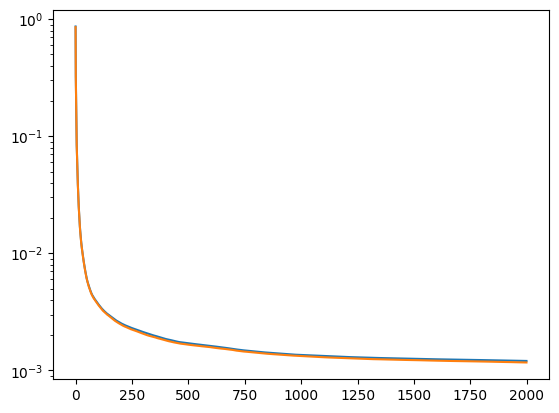

torch.Size([62500, 7])
tensor([ 9.9031e+00, -2.6751e-01, -1.4565e-01,  1.3638e-01, -1.0638e-01,
         3.0383e-02,  2.4750e-02,  1.5744e-02, -3.1921e-03, -7.5553e-03,
        -1.5241e-04,  9.7578e-03,  3.0701e-03,  3.0108e-03, -5.4999e-03,
         1.3939e-03,  1.1683e-03,  4.2778e-04,  2.4167e-04, -1.3883e-03,
        -8.0087e-04, -4.9711e-04,  4.8943e-04, -3.0081e-04,  5.5950e-04,
         5.0105e-04, -9.2536e-04,  3.2806e-04,  4.1859e-04, -2.9581e-04,
        -6.4899e-05,  1.8052e-04,  4.6127e-04, -6.6656e-04, -3.4140e-06,
         5.2200e-04, -3.9068e-05,  1.9042e-04,  1.4352e-04,  3.8378e-04],
       device='cuda:0') tensor([ 9.9031e+00, -2.8748e-01, -1.3890e-01,  1.6120e-01, -1.2783e-01,
         3.4908e-02,  4.4715e-02,  3.3064e-02, -6.0704e-03, -1.1612e-02,
         5.5020e-03,  1.0582e-02, -1.5198e-04,  1.3583e-03, -6.0744e-03,
        -7.2842e-04,  2.1851e-03, -4.8319e-04, -7.7305e-05, -1.6604e-03,
        -6.5167e-04, -6.5348e-04,  8.2485e-04,  3.8054e-05,  7.3696e-04,
   

<ipython-input-3-b445a70b6cef>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, dtype = self.dtype, device = self.device)


In [ ]:
plt.yscale("log")
plt.plot(np.transpose(err)[0])
plt.plot(np.transpose(err)[1])
plt.show()

#dnn.load("/content/drive/MyDrive/POD-NN_brain/NN_inv_brain.npz")
#dnn.cuda()
print(x.shape)
print(y[5000],dnn(GPU.tensor(x[5000])))



In [ ]:
from scipy.stats import qmc
dt=2.0
first=True
dnn.load("/content/drive/MyDrive/POD-NN_brain/NN_phi_brain.npz")
dnn.cuda()
for n in range(2000):
  sampler = qmc.LatinHypercube(d=5)
  sample = sampler.random(n=1)
  l_bounds = [3000,3000,0.27,0.05,0.1,0.0]
  u_bounds = [70000,70000,0.33,0.3,0.3,100.0]
  param=qmc.scale(sample, l_bounds[:-1],u_bounds[:-1])
 
  for ii in range(N_steps):
    if first:
      x_in=np.append(param,ii*dt).reshape(1,6)
      y_out=dnn(GPU.tensor((x_in - np.array(l_bounds))/(np.array(u_bounds)-np.array(l_bounds)))).detach().cpu().numpy().reshape(1,40)
      first=False
    else:
      x_curr=np.append(param,ii*dt).reshape(1,6)
      x_in=np.concatenate([x_in,x_curr],axis=0)
      y_curr=dnn(GPU.tensor((x_curr - np.array(l_bounds))/(np.array(u_bounds)-np.array(l_bounds)))).detach().cpu().numpy().reshape(1,40)
      y_out=np.concatenate([y_out,y_curr],axis=0)



In [ ]:
# PROBLEMA INVERSO
yy = np.load("/content/drive/MyDrive/POD-NN_brain/data_in0.npy")
xx = np.load("/content/drive/MyDrive/POD-NN_brain/data_out_phi0.npy")

for ii in range(1,46):
  y_ = np.load("/content/drive/MyDrive/POD-NN_brain/data_in"+str(ii)+".npy")
  x_ = np.load("/content/drive/MyDrive/POD-NN_brain/data_out_phi"+str(ii)+".npy")
  xx=np.concatenate((xx,x_))
  yy=np.concatenate((yy,y_))

print(x_in.shape)
print(y_out.shape)
print(xx.shape)
print(yy.shape)

xx=np.concatenate((y_out,xx))
yy=np.concatenate((x_in,yy))

l_bounds = np.array([3000,3000,0.27,0.05,0.1,0.0])                                                                  
u_bounds =np.array([70000,70000,0.33,0.3,0.3,100.0])
for (ii,y_row) in enumerate(yy):
  yy[ii] = (y_row - l_bounds)/(u_bounds-l_bounds)

x=[]
y=[]
timesteps=50
print(int(len(xx)/timesteps))

initial_steps=15

for ii in range(int(len(xx)/timesteps)):
  x_loc=xx[timesteps*ii:timesteps*(ii+1)]
  y_loc=yy[timesteps*ii:timesteps*(ii+1)]
  perm1 = np.random.permutation(initial_steps)
  perm2 = perm1+timesteps-initial_steps
  y_=y_loc[:initial_steps,:-1] 
  #diff=y_loc[perm2,-1]-y_loc[perm1,-1]
  x_=np.concatenate((x_loc[perm1],x_loc[perm2]),axis=1)
  if len(x)==0:
    x=x_
    y=y_
  else:
    x=np.concatenate((x,x_))
    y=np.concatenate((y,y_))
print(x.shape,y.shape)
print(x,y)



ntrain = 35*30*initial_steps 
# xx_test=x[4500*initial_steps]
# yy_test=y[4500*initial_steps]

ntest = len(x)-ntrain
xtrain, ytrain =x[:ntrain], y[:ntrain]
xtest, ytest = x[-ntest:], y[-ntest:]


perm1 = np.random.permutation(len(xtrain))
perm2 = np.random.permutation(len(xtest))

xtrain = xtrain[perm1]
xtest = xtest[perm2]
ytrain = ytrain[perm1]
ytest = ytest[perm2]



x = np.vstack([xtrain, xtest])
y = np.vstack([ytrain, ytest])


x = GPU.tensor(x)#.reshape(-1, 1)
y = GPU.tensor(y)#.reshape(-1, 1)
#Normalize inp




xtrain, ytrain = GPU.tensor(x[:ntrain]), GPU.tensor(y[:ntrain])
xtest, ytest = GPU.tensor(x[-ntest:]), GPU.tensor(y[-ntest:])


#y = x.sin()
print(x.shape)
print(y.shape)
#POD


#Costruzione architettura
dnn = Dense(x.shape[1], 500, activation = leakyReLU)+ Dense(500, 500, activation = leakyReLU)+ Dense(500, 500, activation = leakyReLU)  + Dense(500, 500, activation = leakyReLU) + Dense(500, y.shape[1], activation = None)
dnn.He()#Tanh() #He()
dnn.cuda()


(100000, 6)
(100000, 40)
(51000, 40)
(51000, 6)
3020
(45300, 80) (45300, 5)
[[ 9.96584702e+01 -1.48323548e+00  2.24319577e+00 ... -2.31402606e-01
   2.21368462e-01  1.18775152e-01]
 [ 9.97707901e+01 -4.18061209e+00  7.84732103e-01 ... -1.15853995e-01
   1.63816154e-01  1.30999386e-01]
 [ 9.95627136e+01  1.37458253e+00  3.28953838e+00 ... -2.62887090e-01
   2.54802585e-01  9.92513672e-02]
 ...
 [ 9.95344992e+01 -4.81732807e+00 -1.26437028e+00 ... -3.65850864e-01
   3.09751421e-01 -4.03632340e-02]
 [ 9.93587808e+01 -4.58965366e+00 -1.90686469e+00 ... -6.15544962e-01
   5.24705073e-01 -7.07740051e-02]
 [ 9.94424307e+01 -4.71391675e+00 -1.68955191e+00 ... -5.00109055e-01
   4.24811032e-01 -5.70086919e-02]] [[0.95219295 0.33144392 0.29706575 0.29584063 0.34030714]
 [0.95219295 0.33144392 0.29706575 0.29584063 0.34030714]
 [0.95219295 0.33144392 0.29706575 0.29584063 0.34030714]
 ...
 [0.16089127 0.49162039 0.70405989 0.77540444 0.30660291]
 [0.16089127 0.49162039 0.70405989 0.77540444 0.306

<ipython-input-1-b445a70b6cef>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, dtype = self.dtype, device = self.device)


In [ ]:
# PROBLEMA INVERSO

yy = np.load("/content/drive/MyDrive/POD-NN_brain/data_in0.npy")
xx = np.load("/content/drive/MyDrive/POD-NN_brain/data_out_phi0.npy")

for ii in range(1,25):
  y_ = np.load("/content/drive/MyDrive/POD-NN_brain/data_in"+str(ii)+".npy")
  x_ = np.load("/content/drive/MyDrive/POD-NN_brain/data_out_phi"+str(ii)+".npy")
  xx=np.concatenate((xx,x_))
  yy=np.concatenate((yy,y_))

# yy=x_in
# xx=y_out

l_bounds = np.array([800.0,0.05811,0.15,10000.0,0.03,10000.0,0.0])                                                                  
u_bounds =np.array([1800.00,0.15829,0.4,1.0e+06,0.73,1.0e+06,1.225])
for (ii,y_row) in enumerate(yy):
  yy[ii] = (y_row - l_bounds)/(u_bounds-l_bounds)

x=[]
y=[]
timesteps=50
print(int(len(xx)/timesteps))

initial_steps=15

for ii in range(int(len(xx)/timesteps)):
  x_loc=xx[timesteps*ii:timesteps*(ii+1)]
  y_loc=yy[timesteps*ii:timesteps*(ii+1)]
  perm1 = np.random.permutation(initial_steps)
  perm2 = perm1+timesteps-initial_steps
  y_=y_loc[:initial_steps,:-1] 
  #diff=y_loc[perm2,-1]-y_loc[perm1,-1]
  x_=np.concatenate((x_loc[perm1],x_loc[perm2]),axis=1)
  if len(x)==0:
    x=x_
    y=y_
  else:
    x=np.concatenate((x,x_))
    y=np.concatenate((y,y_))
print(x.shape,y.shape)
print(x,y)



ntrain = 25*70*initial_steps 
# xx_test=x[4500*initial_steps]
# yy_test=y[4500*initial_steps]

ntest = len(x)-ntrain
xtrain, ytrain = x[:ntrain], y[:ntrain]
xtest, ytest = x[-ntest:], y[-ntest:]


perm1 = np.random.permutation(len(xtrain))
perm2 = np.random.permutation(len(xtest))

xtrain = xtrain[perm1]
xtest = xtest[perm2]
ytrain = ytrain[perm1]
ytest = ytest[perm2]



x = np.vstack([xtrain, xtest])
y = np.vstack([ytrain, ytest])


x = GPU.tensor(x)#.reshape(-1, 1)
y = GPU.tensor(y)#.reshape(-1, 1)
#Normalize inp




xtrain, ytrain = GPU.tensor(x[:ntrain]), GPU.tensor(y[:ntrain])
xtest, ytest = GPU.tensor(x[-ntest:]), GPU.tensor(y[-ntest:])


#y = x.sin()
print(x.shape)
print(y.shape)
#POD


#Costruzione architettura
dnn = Dense(x.shape[1], 100, activation = leakyReLU)+ Dense(100, 100, activation = leakyReLU)+ Dense(100, 100, activation = leakyReLU)  + Dense(100, 100, activation = leakyReLU) + Dense(100, y.shape[1], activation = None)
dnn.He()#Tanh() #He()
dnn.cuda()


2500
(37500, 80) (37500, 6)
[[ 9.91186038e+00 -7.46839028e-01 -2.55945745e-02 ... -1.46701091e-03
  -6.53216285e-04  1.15546663e-03]
 [ 9.91044239e+00 -6.74725347e-01 -3.85992320e-02 ... -1.93843150e-03
  -1.24783772e-03  1.85886700e-03]
 [ 9.91016660e+00 -6.65402666e-01 -3.95158789e-02 ... -1.99459597e-03
  -1.30865199e-03  1.94770560e-03]
 ...
 [ 9.91778075e+00 -5.10848577e-01 -1.93715504e-01 ... -5.91325657e-04
  -3.38300815e-04  1.79192850e-04]
 [ 9.91750403e+00 -5.40535658e-01 -1.77741846e-01 ... -5.23432201e-04
  -3.02515352e-04  2.07310234e-04]
 [ 9.91814500e+00 -4.18120867e-01 -2.38472226e-01 ... -7.92675425e-04
  -4.37980671e-04  9.78423168e-05]] [[0.28839785 0.16704653 0.00291285 0.84944102 0.81003307 0.1632229 ]
 [0.28839785 0.16704653 0.00291285 0.84944102 0.81003307 0.1632229 ]
 [0.28839785 0.16704653 0.00291285 0.84944102 0.81003307 0.1632229 ]
 ...
 [0.07352946 0.92740667 0.80374087 0.73974294 0.66520431 0.9175875 ]
 [0.07352946 0.92740667 0.80374087 0.73974294 0.6652043

<ipython-input-3-b445a70b6cef>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, dtype = self.dtype, device = self.device)


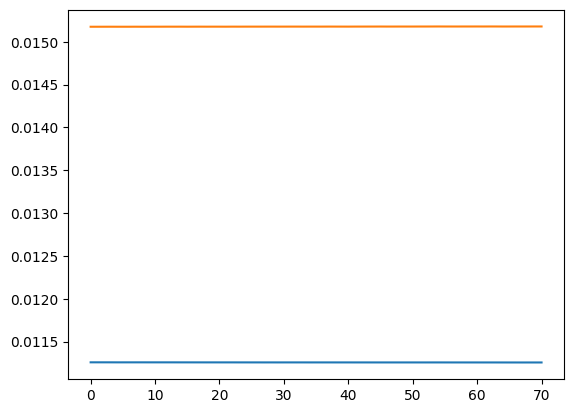

[ 9.94133301e+01 -4.04678583e-01  2.19463277e+00  8.04398596e-01
 -7.03812480e-01  4.89744067e-01  2.13577926e-01  5.79186380e-02
 -1.78564712e-02 -5.74532896e-03 -3.85313407e-02  2.10768394e-02
 -1.71400234e-03  4.79331054e-03 -2.00697221e-03  2.88492814e-03
 -3.45218088e-03 -2.44755745e-02 -2.46712193e-03  8.99708271e-03
 -1.56974308e-02  1.24304723e-02 -8.35860148e-03 -1.34080611e-02
  1.11181885e-02  4.92815301e-02 -2.62484644e-02 -1.30728520e-02
 -3.23456526e-03  4.85448167e-02 -5.46874665e-02  4.24691522e-03
  7.04744160e-02 -3.48075107e-03 -1.07575394e-02 -1.46721601e-02
 -9.35390778e-03 -2.75360197e-02 -1.69468988e-02 -3.05001438e-03
  8.53078308e+01  1.95640678e+01 -1.01866989e+01  5.66305447e+00
 -7.11059284e+00  2.77997375e-01  8.29323006e+00  9.17269289e-01
  2.80696228e-02 -9.99579716e+00 -1.16441631e+01  3.36896092e-01
 -3.15442443e+00  1.16956675e+00 -1.02869773e+00 -8.76551449e-01
 -7.96591854e+00  5.39675856e+00 -3.12928915e+00 -2.40303183e+00
  1.85002828e+00 -4.44671

In [ ]:
plt.plot(np.transpose(err)[0])
plt.plot(np.transpose(err)[1])
plt.show()
print(xx_test)
print(yy_test,dnn(GPU.tensor(xx_test)))



In [ ]:
dnn.save("/content/drive/MyDrive/POD-NN_brain/NN_inv_brain.npz")

In [ ]:
dnn.load("/content/drive/MyDrive/POD-NN_brain/NN_phi_brain.npz")
dnn.cuda()
l_bounds = np.array([3000,3000,0.27,0.05,0.1,0.0])                                                                  
u_bounds =np.array([70000,70000,0.33,0.5,0.3,100.0])
xx_test=[6.25168775e+04, 1.15598711e+04, 3.12576662e-01, 1.08836732e-01, 2.57242034e-01,82.0]
yy_test=dnn(GPU.tensor((xx_test-l_bounds)/(u_bounds-l_bounds))).detach().cpu()
y=yy_test.cpu()
#(y.detach().numpy()+l_bounds[:-1])*(u_bounds[:-1]-l_bounds[-1])
print(y)

tensor([ 9.5347e+01,  2.0684e+01, -9.0370e+00,  3.8774e+00, -3.4258e+00,
        -1.8727e-01,  2.9338e+00,  3.2701e-01,  3.0711e-01, -3.2067e+00,
        -2.9910e+00,  2.5008e-01, -5.3296e-01, -3.5513e-01, -5.8047e-01,
         1.4516e-01, -6.7513e-01,  9.6833e-01, -1.6797e-01, -6.1934e-01,
         7.9101e-01, -4.7780e-01,  6.0468e-01,  2.0548e-02,  1.0007e+00,
        -1.0950e-01,  5.3523e-01, -5.7290e-01, -1.4994e-03, -2.1741e-01,
         2.6660e-01,  3.0955e-01, -1.0023e+00, -3.4104e-01, -7.3772e-01,
         9.1596e-02, -1.5051e-01, -1.5664e-01,  2.5310e-01,  1.6599e-01])


[0.09350491 0.09350491 0.10159297 0.11563185 0.12396373 0.13375595
 0.14401857 0.15929397 0.18218573 0.20335816 0.21324003 0.23835131
 0.26745076 0.30101196 0.32663888 0.34483733 0.38326283 0.40155467
 0.43465148 0.47936765 0.5088634  0.53948527 0.56892254 0.63870122
 0.67910295 0.7214199  0.76586873 0.81342392 0.86594946 0.92813957
 0.97492283 1.03690943 1.08047313 1.15466448 1.21573061 1.27415453
 1.35415463 1.44536416 1.52771856 1.59596603 1.6597097  1.73990045
 1.82751674 1.91423139 2.01898134 2.10689811 2.19235404 2.28234539
 2.39141845 2.48453257 2.58582806 2.67875956 2.77960906 2.93776434
 3.02325219 3.14003042 3.28172331 3.42179321 3.53415352 3.6570079 ] [0.09350491 0.09350491 0.10577577 0.11709405 0.12396373 0.1372175
 0.14603377 0.15929397 0.18694325 0.20335816 0.21324003 0.23835131
 0.26489336 0.30101196 0.32397589 0.34483733 0.38326283 0.40046054
 0.42971298 0.47284205 0.49718368 0.53786691 0.55940677 0.62201799
 0.67271832 0.70716956 0.76068751 0.80184407 0.85273232 0.8989

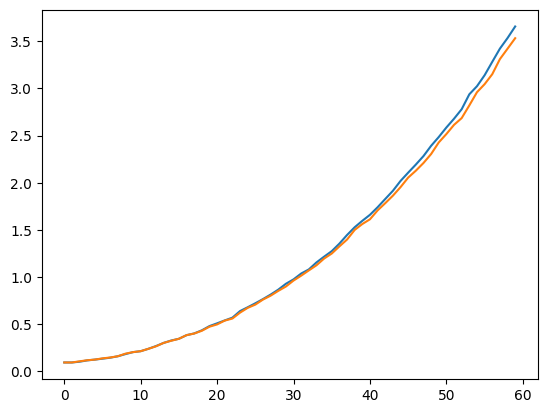

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
v1=np.load("/content/drive/MyDrive/POD-NN_brain/brain_v1.npy")
v2=np.load("/content/drive/MyDrive/POD-NN_brain/brain_v2.npy")
print(v1,v2)
plt.plot(v1)
plt.plot(v2)
#plt.plot(np.transpose(err)[1])
plt.show()